## Attempt to merge lines and objects

In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable tensorflow GPU

import sys
sys.path.insert(0, "src")

In [20]:
! ls input/dutch_samples

0200100000536116_begane.png	      dgw.png
0200100000536116_eerste.png	      funda_rondemaat.png
apeldoorn_0200100000532701_boven.png  hogepad.png
apeldoorn_0200100000532701.png	      laan_oud_indiegangers.png
bim4all_beganegrond.png		      oranjestraat.png
bim4all_eersteverdieping.png	      wellehof.png


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dataset.CubiCasaDatset import CubiCasaDatset
from deeplearning.semantic_segmentation.UNet.UNet import UNetModelBuilder
from deeplearning.semantic_segmentation.Fast_SCNN.Fast_SCNN import Fast_SCNNBuilder
from processing.ocr import TesseractOCR
from processing.image_to_walls import ImageToWalls
from processing.objects_from_detections import process_openings_from_detections
import os

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

from shapely.geometry import LineString, Polygon

In [5]:
%matplotlib inline

In [6]:
image_size = 512
# ds = CubiCasaDatset(image_channels=3,image_size=image_size)

# sample = ds.get_sample(1237)  # 1237 is a simple one 
# to_predict_image = np.array(sample['image'].numpy(),dtype=int)
# fig, (ax1) = plt.subplots(1,1,figsize=(8,8))
# ax1.imshow(to_predict_image)

(512, 512, 3)


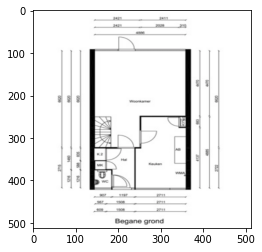

In [21]:
from PIL import Image
from six import BytesIO
to_predict_image = Image.open('input/dutch_samples/0200100000536116_begane.png')
to_predict_image = to_predict_image.convert('RGB')
to_predict_image = to_predict_image.resize((image_size, image_size))
to_predict_image = np.array(to_predict_image, dtype=int)
print(to_predict_image.shape)
plt.imshow(to_predict_image)

## Wall detection

In [22]:
mb = UNetModelBuilder(False)
model = mb.build_model()
model.compile(loss="binary_crossentropy")
model.load_weights('weights/unet/model.h5')

In [23]:
y_pred = model.predict(np.expand_dims(to_predict_image[:,:,0], axis=0))[0] > 0.5

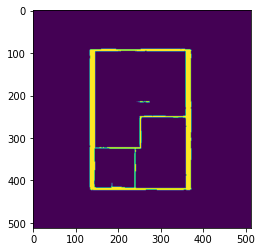

In [24]:
plt.imshow(y_pred)

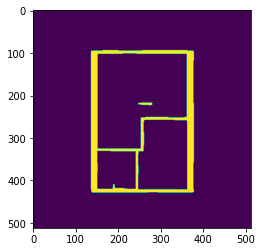

In [25]:
import cv2

image = y_pred.copy() 
kernel = np.ones((10,10),np.uint8)
closing = cv2.morphologyEx(np.float32(image), cv2.MORPH_CLOSE, kernel)

dilation = cv2.dilate(closing,kernel,iterations = 1)
dilation = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)

erosion = cv2.erode(dilation,kernel,iterations = 1)

erosion = cv2.dilate(erosion,np.ones((2,2)),iterations = 3)

gray = cv2.cvtColor(np.flip(np.repeat(erosion.reshape(512,512,1),3, axis=2),axis=0), cv2.COLOR_BGR2GRAY).astype('uint8')

gray = np.flip(gray, axis=0)

plt.imshow(gray)


13 walls found


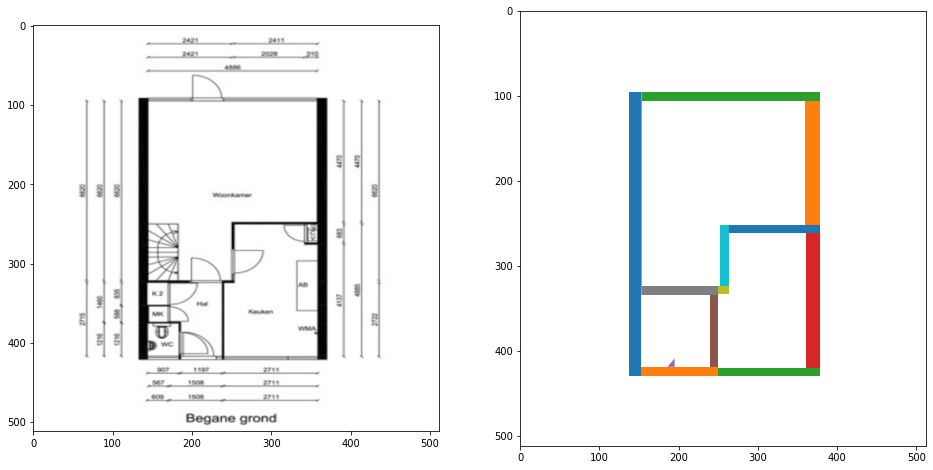

In [33]:
image_to_walls = ImageToWalls()
walls = image_to_walls.do_steps(gray)

print(len(walls), "walls found")

# Display

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.imshow(to_predict_image)    

for wall in walls: 
    ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1])


ax2.set_ylim(image_size,0)
ax2.set_xlim(0,image_size)


plt.show()


13 walls found


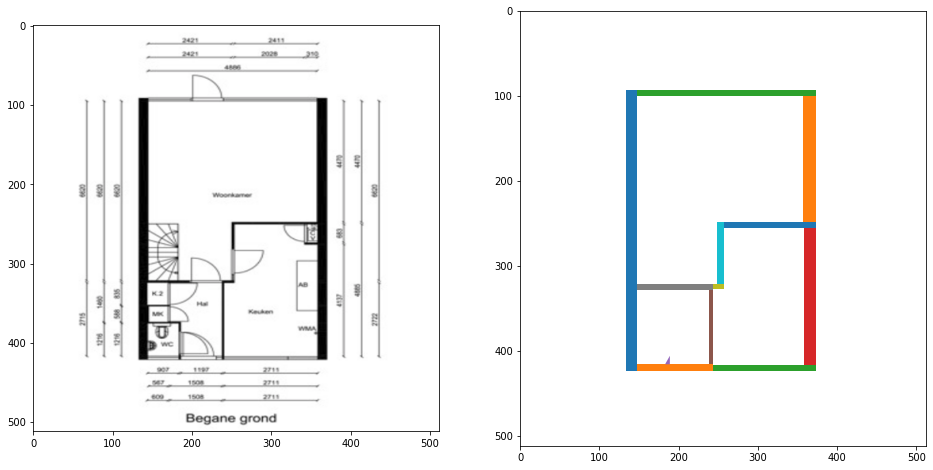

In [26]:
image_to_walls = ImageToWalls()
walls = image_to_walls.do_steps(y_pred)

print(len(walls), "walls found")

# Display

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.imshow(to_predict_image)    

for wall in walls: 
    ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1])


ax2.set_ylim(image_size,0)
ax2.set_xlim(0,image_size)


plt.show()


## Object Detection

In [27]:
mb = Fast_SCNNBuilder()
model = mb.build_model()
# model.compile(loss="binary_crossentropy")
model.load_weights('weights/fast_scnn/model.h5')

In [28]:
# Reload model
pipeline_config_path = "weights/faster_rcnn/stored_model/pipeline.config"
checkpoint_path = "weights/faster_rcnn/stored_model/checkpoint/ckpt-0"

configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(checkpoint_path)

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

#map labels for inference decoding
label_map_path = "src/deeplearning/object_detection/tf_object_detection_api/openings_label_map.pbtxt"
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.6 µs
INFO:tensorflow:depth of additional conv before box predictor: 0


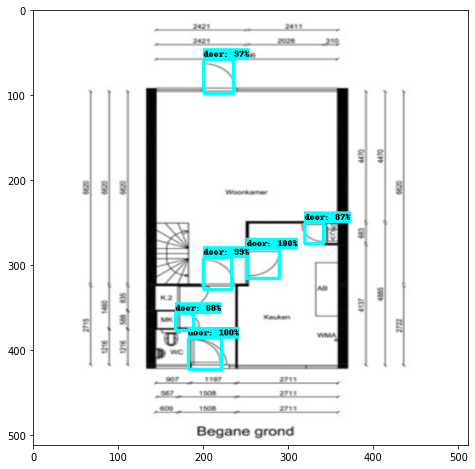

In [29]:
%time

image_np = to_predict_image.copy()
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.3,
      agnostic_mode=False,
)

plt.figure(figsize=(8,8))
plt.imshow(image_np_with_detections)
plt.show()

In [30]:
openings = process_openings_from_detections(detections, walls, image_size)

## OCR

In [31]:
ocr = TesseractOCR()
labels = ocr.extract_labels(to_predict_image)
print(labels)

[('Beganegrond', (187, 483, 313, 511))]


## Merging

(0.0, 512.0)

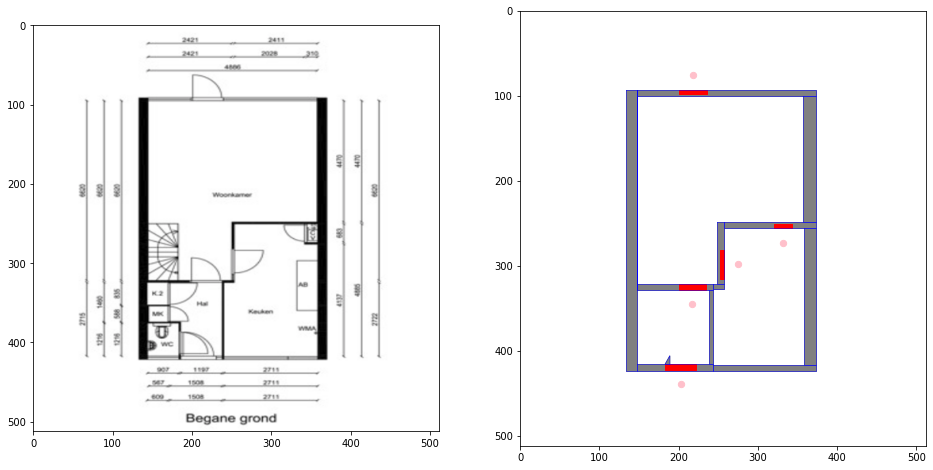

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

ax1.imshow(to_predict_image, cmap="gray")
# ax2.imshow(to_predict_image, cmap="gray")



for wall in walls: 
    ax2.fill(wall.exterior.xy[0],wall.exterior.xy[1],color="grey")
    ax2.plot(wall.exterior.xy[0],wall.exterior.xy[1],color="blue",linewidth=0.5)

for opening in openings:
    opening_poly = opening['polygon']
    ax2.fill(opening_poly.exterior.xy[0],opening_poly.exterior.xy[1],
             color="red" if opening['type'] == "door" else "blue")
    
    center = opening_poly.centroid
    center = [center.xy[0][0], center.xy[1][0]]
    
    # direction: top, right, bottom, left
    if opening['direction'] != None:
        center[1] = center[1] + 20 if opening['direction'] == 0 else center[1]
        center[0] = center[0] + 20 if opening['direction'] == 1 else center[0]
        center[1] = center[1] - 20 if opening['direction'] == 2 else center[1]
        center[0] = center[0] - 20 if opening['direction'] == 3 else center[0]    
        
        ax2.scatter([center[0]], [center[1]],color="pink", s=40)
        

# Show final result
ax1.set_ylim(image_size,0)
ax2.set_ylim(image_size,0)
ax2.set_xlim(0,image_size)


In [23]:
import pickle 
filehandler = open("walls_1742100000008715_boven.obj", 'wb') 
pickle.dump({
    "walls":walls,
    "openings":openings
}, filehandler)